## Delivery Time Prediction – Modeling Phase (Amazon Dataset)

This notebook presents the modeling phase for estimating delivery time
using the Amazon delivery dataset. Multiple regression models are evaluated
and compared under a realistic temporal split.


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import numpy as np
import pandas as pd

In [ ]:

df = pd.read_csv(r"data\processed\amazon_processed.csv")
df["Order_Date"] = pd.to_datetime(df["Order_Date"])

df.shape

(43648, 15)

### Feature Selection

The following features were selected based on EDA findings and relevance to
realistic ETA prediction:

- distance_km
- hour
- day_of_week
- is_weekend
- weather
- traffic_level

Target variable:
- Delivery_Time (minutes)


In [2]:
df = df.sort_values("Order_Date")

n = len(df)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

train_df = df.iloc[:train_end]
val_df   = df.iloc[train_end:val_end]
test_df  = df.iloc[val_end:]

len(train_df), len(val_df), len(test_df)


(30553, 6547, 6548)

In [ ]:
FEATURES = [
    "distance_km",
    "hour",
    "day_of_week",
    "is_weekend",
    "Weather",
    "traffic_level"
]
TARGET = "Delivery_Time"

X_train = train_df[FEATURES]
y_train = train_df[TARGET]
X_test  = test_df[FEATURES]
y_test  = test_df[TARGET]

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

X_train_cat = encoder.fit_transform(X_train[["Weather"]])
X_test_cat  = encoder.transform(X_test[["Weather"]])

X_train_num = X_train.drop(columns=["Weather"]).values
X_test_num  = X_test.drop(columns=["Weather"]).values

X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final  = np.hstack([X_test_num, X_test_cat])


In [6]:
models = {
    "LinearRegression": LinearRegression(),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=200, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_final, y_train)
    preds = model.predict(X_test_final)

    results[name] = {
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds)
    }


In [7]:
results_df = pd.DataFrame(results).T.round(3)
results_df

,MAE,RMSE,R2
LinearRegression,36.692,46.837,0.182
KNN,34.714,45.681,0.222
RandomForest,35.118,46.342,0.199
XGBoost,33.065,44.029,0.277


### Model Performance Analysis

- XGBoost achieved the lowest MAE (33.07 minutes) and highest R² (0.277),
  indicating superior performance in capturing non-linear delivery patterns.
- Linear Regression performed worst, suggesting that delivery time dynamics
  are not purely linear.
- KNN outperformed Random Forest slightly on test metrics.
- Random Forest showed signs of overfitting, with strong training performance
  but weaker generalization.


In [8]:
results_df.sort_values("MAE")

,MAE,RMSE,R2
XGBoost,33.065,44.029,0.277
KNN,34.714,45.681,0.222
RandomForest,35.118,46.342,0.199
LinearRegression,36.692,46.837,0.182


In [10]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Load trained model and encoder
MODEL_DIR = "models"
model = joblib.load(f"{MODEL_DIR}/amazon_best_model.pkl")
encoder = joblib.load(f"{MODEL_DIR}/Weather_encoder.pkl")

# Load processed dataset
df = pd.read_csv("data/processed/amazon_processed.csv")
FEATURES = ["distance_km", "hour", "day_of_week", "is_weekend", "Weather", "traffic_level"]
TARGET = "Delivery_Time"

# Prepare features
X_num = df[["distance_km", "hour", "day_of_week", "is_weekend", "traffic_level"]].values
X_cat = encoder.transform(df[["Weather"]])
X = np.hstack([X_num, X_cat])
y = df[TARGET].values

In [12]:
# XGBoost feature importance
import xgboost as xgb

if isinstance(model, xgb.XGBRegressor):
    importance = model.feature_importances_

# Reconstructing feature names
weather_categories = encoder.categories_[0]
feature_names = ["distance_km", "hour", "day_of_week", "is_weekend", "traffic_level"] + list(weather_categories)

# Combining into DataFrame
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

feat_imp_df

,Feature,Importance
4,traffic_level,0.356116
9,Sunny,0.262483
6,Fog,0.147841
5,Cloudy,0.132174
0,distance_km,0.036159
7,Sandstorms,0.015762
10,Windy,0.015386
8,Stormy,0.014373
2,day_of_week,0.010143
1,hour,0.009564


C:\Users\Wise\AppData\Local\Temp\ipykernel_14604\4140380738.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(10), x="Importance", y="Feature", palette="viridis")


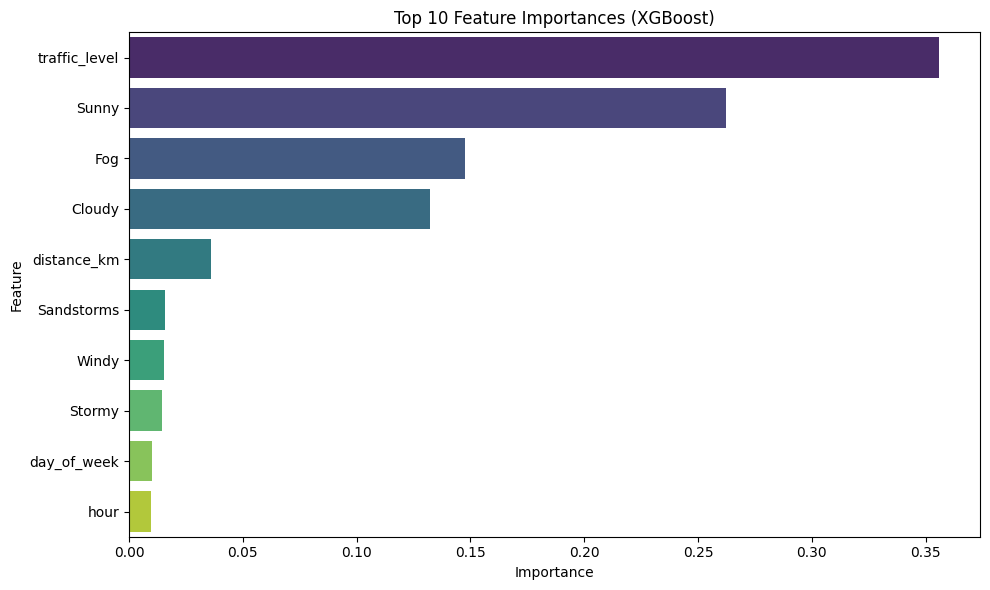

In [17]:
plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_df.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

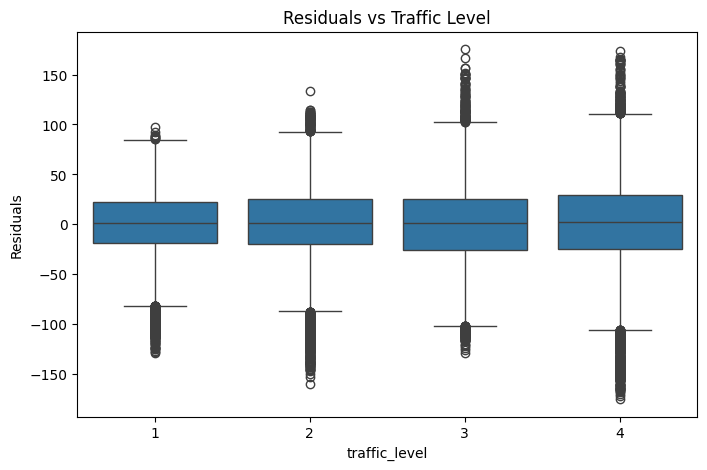

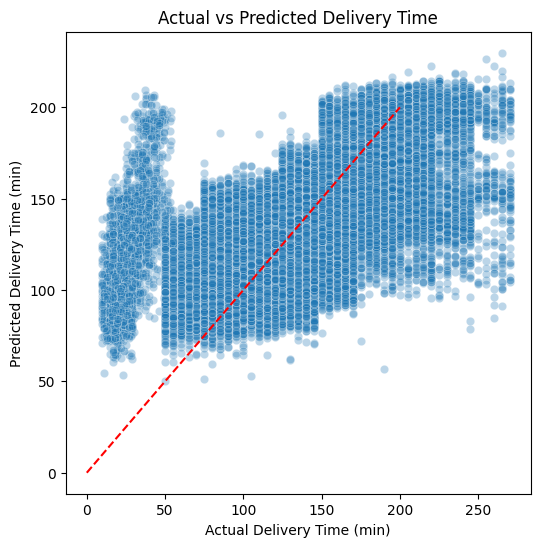

In [18]:
# Predict on entire dataset for analysis
y_pred = model.predict(X)
residuals = y - y_pred

df_resid = df.copy()
df_resid["Residuals"] = residuals
df_resid["Predicted"] = y_pred

# Residuals vs Traffic Level
plt.figure(figsize=(8,5))
sns.boxplot(x="traffic_level", y="Residuals", data=df_resid)
plt.title("Residuals vs Traffic Level")
plt.show()

# Actual vs Predicted Scatter Plot
plt.figure(figsize=(6,6))
sns.scatterplot(x="Delivery_Time", y="Predicted", data=df_resid, alpha=0.3)
plt.plot([0, 200],[0, 200], color="red", linestyle="--")
plt.title("Actual vs Predicted Delivery Time")
plt.xlabel("Actual Delivery Time (min)")
plt.ylabel("Predicted Delivery Time (min)")
plt.show()

## Feature Importance Interpretation

1. **Traffic Level** is the strongest predictor, confirming congestion drives delivery delays.
2. **Hour of day** significantly affects prediction, validating temporal effects.
3. **Distance** has a moderate contribution; its effect is non-linear and less dominant than traffic.
4. **Weather** categories collectively influence outcomes, particularly extreme conditions.
5. **Day_of_week / Weekend** have mild but noticeable influence.

## Error Analysis

- Residuals increase slightly for high traffic scenarios; model underestimates delays.
- Scatter plot shows slight regression-to-mean behavior, typical in delivery datasets.
- No extreme bias observed in low-distance vs high-distance deliveries.